### 1. Set up the analysis

In [1]:
# Import necessary libraries
import os
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterstats as rs
import earthpy as et

import clean

# Download data from EarthPy
data = et.data.get_data("spatial-vector-lidar")

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

### 2. Define paths to the data

In [2]:
# Define base sjer data path
sjer_base_path = os.path.join(
    'spatial-vector-lidar', 'california', 'neon-sjer-site')

# Define path to sjer plot locations
sjer_points_path = os.path.join(
    sjer_base_path, 'vector_data', 'SJER_plot_centroids.shp')

# Define sjer lidar data path
sjer_chm_path = os.path.join(
    sjer_base_path, '2013', 'lidar', 'SJER_lidarCHM.tif')

# Define sjer insitu data path
sjer_insitu_path = os.path.join("spatial-vector-lidar",
                                "california",
                                "neon-sjer-site",
                                "2013",
                                "insitu",
                                "veg_structure",
                                "D17_2013_SJER_vegStr.csv")

In [3]:
# Define base soap data path
soap_base_path = os.path.join(
    'spatial-vector-lidar', 'california', 'neon-soap-site')

# Define path to soap plot locations
soap_points_path = os.path.join(
    soap_base_path, 'vector_data', 'SOAP_centroids.shp')

# Define soap lidar data path
soap_chm_path = os.path.join(
    soap_base_path, '2013', 'lidar', 'SOAP_lidarCHM.tif')

# Define sjer insitu data path
soap_insitu_path = os.path.join("spatial-vector-lidar",
                                "california",
                                "neon-soap-site",
                                "2013",
                                "insitu",
                                "veg-structure",
                                "D17_2013_SOAP_vegStr.csv")

### 3. Create functions to process the data

In [4]:
# Function 1
def lidar_max_mean(site_points_path, site_chm_path):
    """
    Calculate max and mean tree heights for LiDAR data.

    Parameters
    ----------
    site_points_path : str
      The path to plot locations data for a chosen site.

    site_chm_path : str
      The path to LiDAR CHM data for a chosen site.

    Returns
    -------
    site_lidar_gdf : gpd.GeoDataFrame
      gdf with max and mean LiDAR tree height values.
    """
    site_plots = gpd.read_file(site_points_path)

    # Buffer the points to represent the full plot boundary
    site_plots['geometry'] = site_plots.geometry.buffer(20)

    # Compute mean and max tree height for each plot
    site_lidar = rs.zonal_stats(
        site_plots, site_chm_path,
        geojson_out=True, nodata=0, copy_properties=True,
        stats=['max', 'mean'])

    # Turn the data into a gdf
    site_lidar_gdf = gpd.GeoDataFrame.from_features(site_lidar)

    site_lidar_gdf = site_lidar_gdf.rename(
        columns={'max': 'lidar_max',
                 'mean': 'lidar_mean'})

    return site_lidar_gdf

In [5]:
# Function 2
def insitu_max_mean(site_insitu_path):
    """
    Calculate max and mean tree heights for insitu data.

    Parameters
    ----------
    site_insitu_path : str
      The path to insitu tree heights data.

    Returns
    -------
    site_insitu_gdf : gpd.GeoDataFrame
      gdf with max and mean insitu tree height values.
    """
    site_insitu = pd.read_csv(site_insitu_path)

    # Summarize insitu data
    site_insitu_grp = site_insitu.groupby(
        'plotid').stemheight.agg(['max', 'mean']).reset_index()

    # Rename columns
    site_insitu_gdf = site_insitu_grp.rename(
        columns={'max': 'insitu_max', 'mean': 'insitu_mean'})

    return site_insitu_gdf

In [6]:
# Function 3
def merge_and_plot(site_lidar_gdf, site_insitu_gdf, field_site_name,
                   ax1_xlim, ax1_ylim, ax2_xlim, ax2_ylim):
    """
    Merge LiDAR & insitu datasets and plot tree height values.

    Parameters
    ----------
    site_lidar_gdf : gpd.GeoDataFrame
      gdf with max and mean LiDAR tree height values.

    site_insitu_gdf : gpd.GeoDataFrame
      gdf with max and mean insitu tree height values.

    field_site_name : str
      The name of the field site of interest.

    ax1_xlim : (int, int)
      The range of x limits for ax1.

    ax1_ylim : (int, int)
      The range of y limits for ax1.

    ax2_xlim : (int, int)
      The range of x limits for ax2.

    ax2_ylim : (int, int)
      The range of y limits for ax2.

    Returns
    -------
    figure : axes 
      LiDAR/insitu tree height comparison and analysis
    """
    site_lidar_gdf = site_lidar_gdf[[
        'Plot_ID', 'geometry', 'lidar_max', 'lidar_mean']]

    # Merge two datasets
    site_lidar_insitu_gdf = site_lidar_gdf.merge(site_insitu_gdf,
                                                 left_on='Plot_ID',
                                                 right_on='plotid')

    # Create figure with axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    sns.regplot('lidar_max', 'insitu_max',
                data=site_lidar_insitu_gdf,
                color='purple',
                ax=ax1)

    # 1:1 line for ax1
    ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
    ax1.set(xlabel='Max Lidar Height(m)',
            ylabel='Max InSitu Height(m)',
            title='Lidar Max vs. InSitu Max Tree Height\n'
                   '{} Field Site'.format(field_site_name),
            xlim=ax1_xlim,
            ylim=ax1_ylim)

    sns.regplot('lidar_mean', 'insitu_mean',
                data=site_lidar_insitu_gdf,
                color='purple',
                ax=ax2)

    # 1:1 line for ax2
    ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')
    ax2.set(xlabel='Mean Lidar Height(m)',
            ylabel='Mean InSitu Height(m)',
            title='Lidar Mean vs. InSitu Mean Tree Height\n'
                   '{} Field Site'.format(field_site_name),
            xlim=ax2_xlim,
            ylim=ax2_ylim)

    plt.show()

    return

### 4. Run the workflow using created functions

In [7]:
# Process the LiDAR data
sjer_site_lidar_stats = lidar_max_mean(site_points_path=sjer_points_path,
                                       site_chm_path=sjer_chm_path)

soap_site_lidar_stats = lidar_max_mean(site_points_path=soap_points_path,
                                       site_chm_path=soap_chm_path)

soap_site_lidar_stats['ID'] = 'SOAP' + soap_site_lidar_stats['ID']
soap_site_lidar_stats = soap_site_lidar_stats.rename(
    columns={'ID': 'Plot_ID'})

In [8]:
# Process the insitu data
sjer_site_insitu_stats = insitu_max_mean(site_insitu_path=sjer_insitu_path)
soap_site_insitu_stats = insitu_max_mean(site_insitu_path=soap_insitu_path)

/Users/stepan/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


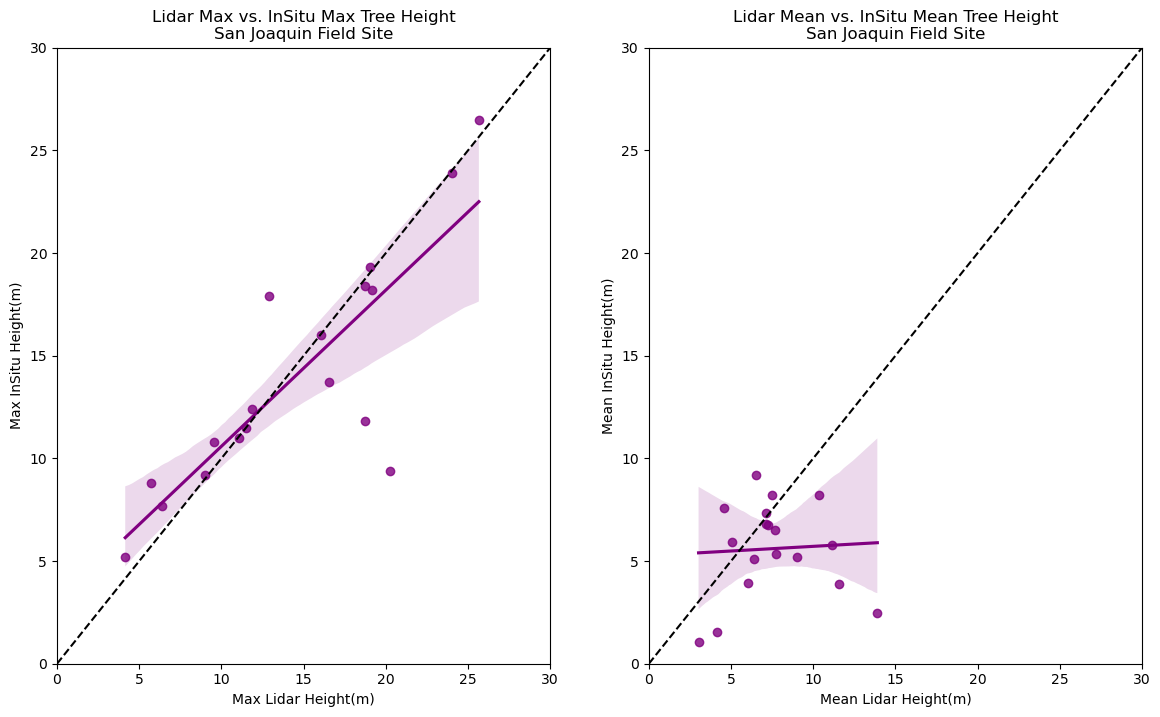

In [9]:
# Merge SJER datasets and create plots
merge_and_plot(sjer_site_lidar_stats,
               sjer_site_insitu_stats,
               field_site_name='San Joaquin',
               ax1_xlim=(0, 30), ax1_ylim=(0, 30),
               ax2_xlim=(0, 30), ax2_ylim=(0, 30))

/Users/stepan/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


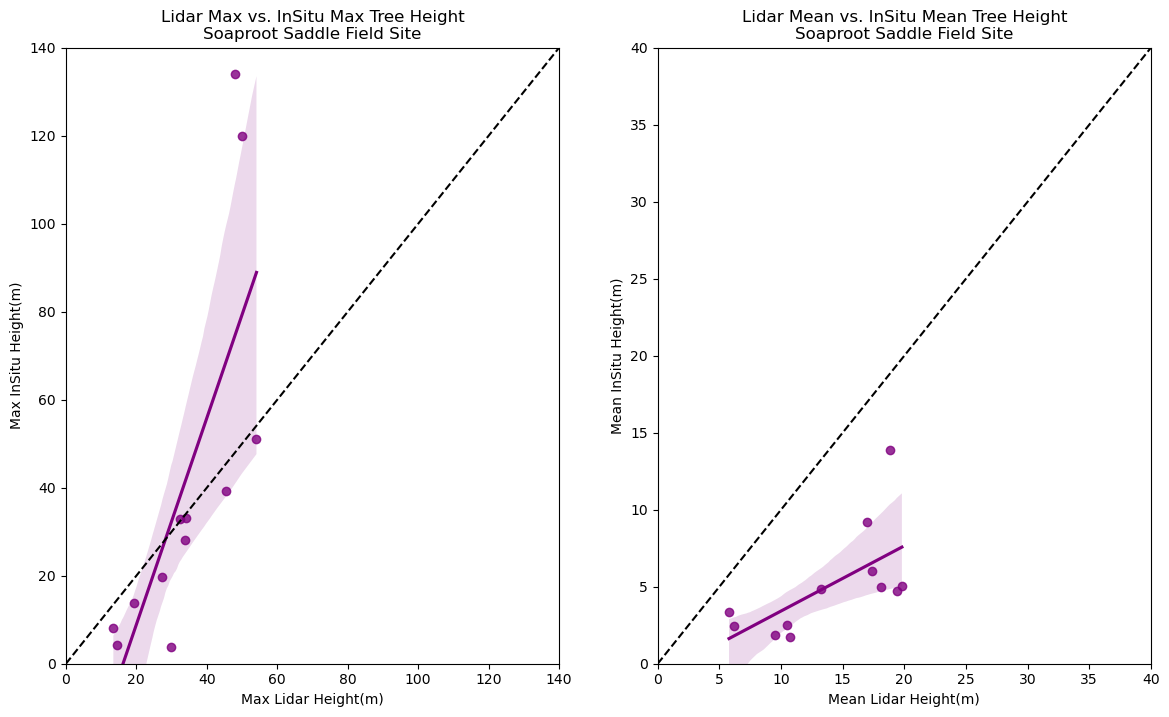

In [10]:
# Merge SOAP datasets and create plots
merge_and_plot(soap_site_lidar_stats,
               soap_site_insitu_stats,
               field_site_name='Soaproot Saddle',
               ax1_xlim=(0, 140), ax1_ylim=(0, 140),
               ax2_xlim=(0, 40), ax2_ylim=(0, 40))

In [11]:
print(clean.MY_VARIABLE)

Have a nice day!
